In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from IPython.display import clear_output, display

## Modeling

In [2]:
features = [
    'asst_tot', 'asst_tot_quantile_values',
    'financial_leverage', 'financial_leverage_quantile_values',
    'profitability_ratio', 'profitability_ratio_quantile_values',
    'net_income_growth', 'net_income_growth_quantile_values',
    'quick_ratio_v2', 'quick_ratio_v2_quantile_values',
    'sales_growth', 'sales_growth_quantile_values',
    'cash_assets_ratio', 'cash_assets_ratio_quantile_values',
    'dscr', 'dscr_quantile', 'ebitda','is_first_occurrence'
]

In [3]:
df = pd.read_csv('../data/processed_data.csv')
df.shape

(1023552, 72)

In [4]:
modeling_df = df.drop(['def_date'],axis=1)
modeling_df.isna().sum().sort_values().tail(10)
modeling_df.shape

(1023552, 71)

In [5]:
# modeling_df['HQ_city'] = modeling_df['HQ_city'].fillna(-1.0)

In [6]:
modeling_df[~modeling_df.index.isin(modeling_df.dropna().index)]['default'].value_counts()

default
0    1010614
1      12938
Name: count, dtype: int64

In [7]:
modeling_df = modeling_df[modeling_df['is_first_occurrence']==0]
print(modeling_df.shape)
len(modeling_df)/len(df)

(785841, 71)


0.767758746013881

In [8]:
modeling_df['default'].mean()

np.float64(0.013422562579453096)

In [9]:
 modeling_df['sales_growth'] = modeling_df['sales_growth'].replace([np.inf,-np.inf],0)

In [10]:
modeling_df[features].isna().sum(axis=0)

asst_tot                               0
asst_tot_quantile_values               0
financial_leverage                     0
financial_leverage_quantile_values     1
profitability_ratio                    0
profitability_ratio_quantile_values    1
net_income_growth                      0
net_income_growth_quantile_values      1
quick_ratio_v2                         0
quick_ratio_v2_quantile_values         0
sales_growth                           0
sales_growth_quantile_values           0
cash_assets_ratio                      0
cash_assets_ratio_quantile_values      0
dscr                                   0
dscr_quantile                          0
ebitda                                 0
is_first_occurrence                    0
dtype: int64

In [11]:
### we'll try dropping NA's for now
modeling_df = modeling_df[~(modeling_df[features].isna().sum(axis=1)>0)].copy()

In [12]:
modeling_df.sort_values('stmt_date', inplace=True)

In [13]:
train_df = modeling_df.iloc[:int(len(modeling_df)*0.8)]

In [14]:
test_df = modeling_df[~modeling_df.index.isin(train_df.index)]

In [15]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [16]:
# test_df[feature_list].isna().sum()

In [17]:
quantile_features = [
  'asst_tot_quantile_values',
 'financial_leverage_quantile_values',
 'profitability_ratio_quantile_values',
 'net_income_growth_quantile_values',
 'quick_ratio_v2_quantile_values',
 'sales_growth_quantile_values',
 'cash_assets_ratio_quantile_values',
 'dscr_quantile',
    # 'ebitda',
    # 'is_first_occurrence'
]


In [18]:
# train_df[quantile_features]

In [19]:
# feature_list = [
#                 'HQ_city',
#                  'legal_struct',
#                  'ateco_sector',
#                   'asst_tot',
#                  'financial_leverage',
#                  'profitability_ratio',
#                  'profit',
#                  'net_income_growth',
#                  'quick_ratio_v2',
#                  'sales_growth',
#                  'cash_assets_ratio',
#                  'dscr'
#                  ]

In [20]:
formula = 'default ~ '+' + '.join(quantile_features)
formula

'default ~ asst_tot_quantile_values + financial_leverage_quantile_values + profitability_ratio_quantile_values + net_income_growth_quantile_values + quick_ratio_v2_quantile_values + sales_growth_quantile_values + cash_assets_ratio_quantile_values + dscr_quantile'

In [21]:
model = smf.logit(formula, data = train_df) 
logit_model_sm = model.fit()
print(logit_model_sm.summary())

Optimization terminated successfully.
         Current function value: 0.066890
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                default   No. Observations:               628672
Model:                          Logit   Df Residuals:                   628663
Method:                           MLE   Df Model:                            8
Date:                Sat, 09 Nov 2024   Pseudo R-squ.:                  0.1239
Time:                        16:36:01   Log-Likelihood:                -42052.
converged:                       True   LL-Null:                       -47997.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -4.6967      0.113

In [23]:
print(logit_model_sm.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:                default
Method:                          dydx
At:                           overall
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
asst_tot_quantile_values                1.3806      0.101     13.609      0.000       1.182       1.579
financial_leverage_quantile_values      0.0317      0.003     11.535      0.000       0.026       0.037
profitability_ratio_quantile_values     0.1294      0.002     54.694      0.000       0.125       0.134
net_income_growth_quantile_values       0.0199      0.013      1.550      0.121      -0.005       0.045
quick_ratio_v2_quantile_values         -0.2090      0.030     -6.947      0.000      -0.268      -0.150
sales_growth_quantile_values            0.2228      0.042      5.287      0.000       0.140       0.305
cash_assets_rati

In [24]:
predictions = test_df[['default']].copy()
predictions['predicted_probability'] = logit_model_sm.predict(test_df)
# predictions.dropna(inplace=True)
predictions.head()

,default,predicted_probability
558626,0,0.011639
899323,0,0.015703
4527,0,0.003041
468142,0,0.006373
104459,0,0.026148


In [25]:
predictions['predicted_probability'].describe()

count    157168.000000
mean          0.014875
std           0.024700
min           0.000893
25%           0.004060
50%           0.008819
75%           0.018830
max           0.612731
Name: predicted_probability, dtype: float64

In [26]:
predictions['predicted_probability'].min()

np.float64(0.0008933553944820495)

In [27]:
predictions['default'].mean()

np.float64(0.008576809528657234)

In [28]:
from sklearn.calibration import CalibratedClassifierCV

In [29]:
cal_model = CalibratedClassifierCV

0.5107583171849726 0.6127313095430706


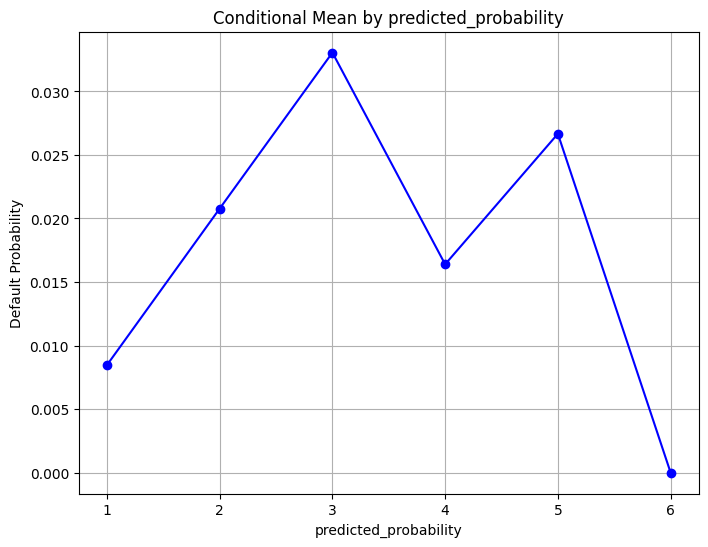

In [30]:
field = 'predicted_probability'
# custom_bins = [0,.10,.11,.12,.13,.14,.19]
cut, bins = pd.cut(predictions['predicted_probability'], bins=6, labels=False, retbins=True, duplicates = 'drop')
cut+=1# Adding 1 to make quantiles start from 1
default_prob_values = predictions.groupby(cut)[['default']].mean()
# print(bins)
print(bins[-2],bins[-1])
plt.figure(figsize=(8, 6))
plt.plot(default_prob_values.index, default_prob_values.default, marker='o', linestyle='-', color='b')
plt.title(f'Conditional Mean by {field}')
plt.xlabel(field)
plt.ylabel('Default Probability')
plt.grid(True)
plt.show()

In [31]:
predictions['predicted_probability'].min()

np.float64(0.0008933553944820495)

In [32]:
from sklearn import metrics

In [33]:
metrics.roc_auc_score(y_score=predictions['predicted_probability'], y_true=predictions['default'])

np.float64(0.7862692848820847)

In [34]:
import seaborn as sns
sns.set()

<Axes: xlabel='predicted_probability', ylabel='Count'>

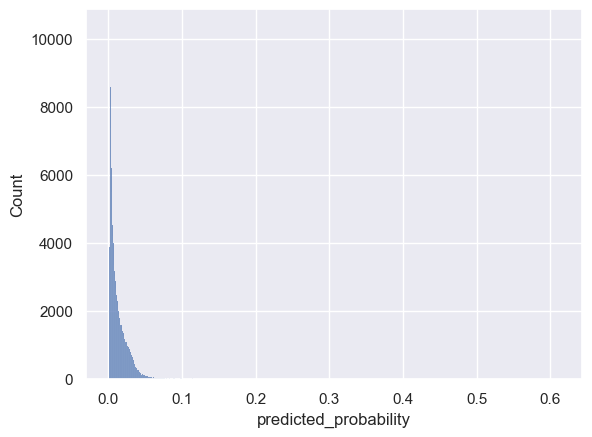

In [35]:
sns.histplot(predictions['predicted_probability'])

ROC AUC 0.7862692848820847


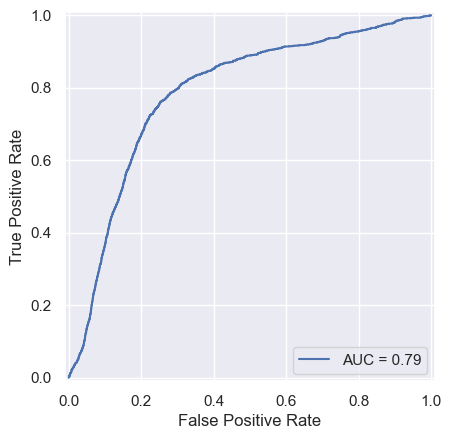

In [36]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['default'], predictions['predicted_probability'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

## Walk forward

In [37]:
def predictor(new_df, model):
    predictions = model.predict(new_df)
    return(predictions)

In [38]:
def preprocessor(df, preproc_params = {}, new = True):

    quantiles = preproc_params['quantiles']
    
    to_quantile_features = ['asst_tot',
                 'financial_leverage',
                 'profitability_ratio',
                 'profit',
                 # 'net_income_growth',
                 'quick_ratio_v2',
                 # 'sales_growth',
                 'cash_assets_ratio',
                 'dscr']

    feature_names = []
    
    for feature in to_quantile_features:
        if new:
            cut, bins = pd.qcut(df[feature], q=quantiles, retbins=True,labels=False, duplicates='drop')
            
            prob_values = df.groupby(cut)[['default']].mean()

            feature_name = f'{feature}_quantile_value'
            feature_names.append(feature_name)
            
            df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']
            preproc_params['quantile_bins'][feature] = bins
            
        else:
            if feature not in preproc_params['quantile_bins']:
                raise Exception("Error bins haven't been fitted")
            bins = preproc_params['quantile_bins'][feature]
            
            cut = pd.cut(df[feature], bins=bins, labels=False, include_lowest=True)
            prob_values = df.groupby(cut)[['default']].mean()

            feature_name = f'{feature}_quantile_value'
            feature_names.append(feature_name)
            
            df[feature_name] = cut.to_frame().join(prob_values, how='left',on= feature)['default']

    preproc_params['features'] = feature_names
    
    return(df, preproc_params)

In [39]:
def estimator(df, fitting_algo, est_params = {}):
    
    my_formula = est_params['formula']
    model = fitting_algo(my_formula, data = df) 
    fitted_model = model.fit(disp=False)
    
    return(fitted_model)

In [40]:
def progress_bar(k, n, incr_txt="Step", bar_len = 10):
   
    bar_char  = u'\u25A5'
    line_char = u'\u21E2' # u'\u2192'  u'\u23AF' u'\u25AD'
    
    places   = int(np.ceil(n/bar_len))
    pct      = k/n
    n_str    = "{:,.0f}".format(n)        
    k_str    = "{:,.0f}".format(k)
    pct_str  = "{:,.0f}%".format(k/n * 100)
    # d_format = "%" + str(places) + "d"
    
    if k == n-1:
        n_bars = bar_len
        n_spaces = 0
        text_txt = "Completed " + n_str + " " + incr_txt + "s."
    else:
        n_bars   = int(np.floor(pct * bar_len))
        n_spaces = bar_len - n_bars
        text_txt = " " + pct_str +  " (" + incr_txt + " " + k_str + " of  " + n_str + ")."

    bar_txt  = "[" + "".ljust(n_bars,bar_char) + "".rjust(n_spaces,line_char) + "]  " 

    clear_output()
    display(bar_txt + text_txt)

In [41]:
def walk_forward_harness(df, preprocessor, estimator, predictor, 
                         start, date_col = 'Date', step_size = 1):     
    predictions = []
    model_list = []
    group_list = []
    
    stats_list = []
    def_percent = []

    labels = []

    preproc_params = {
        'quantiles':20,
        'quantile_bins':{},
        'features': quantile_features
    }
    
    
    df[date_col] = pd.to_datetime(df[date_col])
    walk_range = df[date_col].dt.year.unique()
    
    for i in range(start,len(walk_range), step_size):
        
        train_idx = walk_range[:i]
        test_idx = [walk_range[i]]

        # print('train',train_idx)
        # print('test',test_idx)
        
        train_data = df[df[date_col].dt.year.isin(train_idx)].copy()
        test_data = df[df[date_col].dt.year.isin(test_idx)].copy()
        
        # train_data_proc , preproc_params = preprocessor(train_data, preproc_params, new=True)
        # test_data_proc , preproc_params = preprocessor(test_data, preproc_params, new=False)
        train_data_proc = train_data
        test_data_proc = test_data
        
        algo_params = {'formula': 'default ~ '+' + '.join(preproc_params['features'])}
        
        algo = smf.logit
    
        trained_model = estimator(train_data_proc, algo, algo_params)
        prediction = predictor(test_data_proc, trained_model)
        
        
        labels += list(test_data['default'].values)
        predictions += list(prediction.values)
        
        group_list += test_idx * len(prediction.values)
        
        try:
            preds = pd.DataFrame([labels,predictions,group_list]).T
            preds.columns = ['label','prediction','group']
            preds = preds.dropna()
            score = metrics.roc_auc_score(y_score=preds['prediction'], y_true=preds['label'])
            
        except Exception as e:
            print(F'Error scoring {e}')
            score = np.nan

        
        stats_list.append(score)
        model_list.append(trained_model)
        

        progress_bar(i, len(walk_range))
    
    predictions = pd.DataFrame([labels,predictions,group_list]).T
    predictions.columns = ['label','prediction','group']
    #predictions.set_index('index', inplace=True)
    
    return(predictions, model_list, stats_list)

In [42]:
predictions, model_list, stats_list = walk_forward_harness(modeling_df,
                                                           preprocessor = preprocessor, 
                                                           estimator = estimator, 
                                                           predictor = predictor, 
                                                           date_col = 'stmt_date',
                                                           start = 1, 
                                                           step_size = 1)

'[▥▥▥▥▥▥▥▥▥▥]  Completed 5 Steps.'

In [43]:
predictions.isna().sum()

label         0
prediction    0
group         0
dtype: int64

In [44]:
predictions = predictions.dropna()

ROC AUC 0.7753165264285568


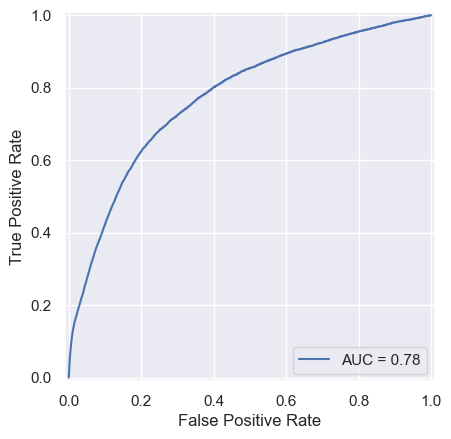

In [45]:
fpr, tpr, thresholds = metrics.roc_curve(predictions['label'], predictions['prediction'])
roc_auc = metrics.auc(fpr, tpr)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
print(f'ROC AUC {roc_auc}')
roc_display.plot()

Text(0, 0.5, 'ROC AUC score (for that test set of size Step)')

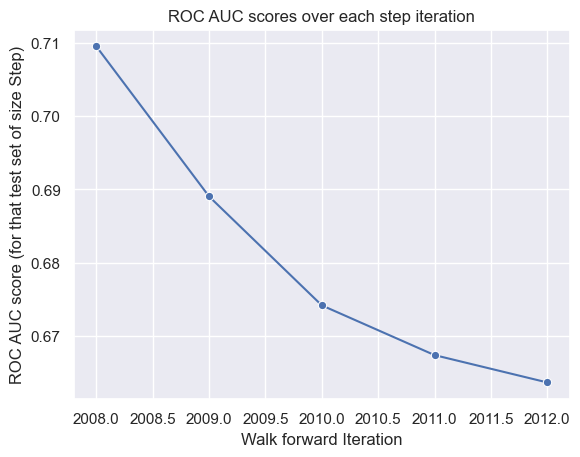

In [56]:
sns.lineplot(x=predictions['group'].unique(), y=stats_list, marker="o")
plt.title('ROC AUC scores over each step iteration')
plt.xlabel('Walk forward Iteration')
plt.ylabel('ROC AUC score (for that test set of size Step)')

In [57]:
default_data_viz = predictions.groupby('group')['label'].mean()

Text(0, 0.5, '% of defaults')

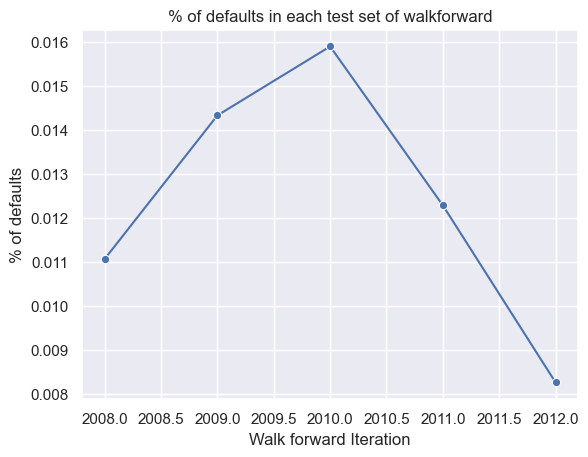

In [58]:
sns.lineplot(x=default_data_viz.index, y=default_data_viz, marker="o")
plt.title('% of defaults in each test set of walkforward')
plt.xlabel('Walk forward Iteration')
plt.ylabel('% of defaults')